# IS 6813 - MSBA Capstone - Spring 2023
## Modeling Assignment
### Jordan Harmer

In [1]:
# import libraries
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor



In [2]:
#read in files
sales_df = pd.read_excel('FSOP_Sales_Data_v2.0.xlsb')
cust_df = pd.read_excel('FSOP_Customer_Data_v2.0.xlsb')

### Business Problem:

To determine the profitability of a new business (and to make pricing and funding decisions accordingly), Swire needs to improve their ability to predict the popularity, longevity, and total 3-year sales volume of new customers based on historical results. 

The business problem at Swire Coca-Cola is to accurately predict these three indicators: (1) popularity, (2) longevity, and (3) total 3-year sales volume of new restaurant customers to make informed pricing and funding decisions.

In [3]:
# Merge the sales and customer data into one dataframe
# new_df = pd.merge(sales_df, cust_df, on='CUSTOMER_NUMBER_BLINDED', how='left')

## Data Prep

In [4]:
sales_df.info()
cust_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 831858 entries, 0 to 831857
Data columns (total 15 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   CUSTOMER_NUMBER_BLINDED           831858 non-null  object 
 1   PRODUCT_SOLD_BLINDED              831858 non-null  object 
 2   BEV_CAT_DESC                      758235 non-null  object 
 3   CALORIE_CAT_DESC                  758235 non-null  object 
 4   PACK_TYPE_DESC                    831858 non-null  object 
 5   PACK_SIZE_SALES_UNIT_DESCRIPTION  831858 non-null  object 
 6   PHYSICAL_VOLUME                   831858 non-null  float64
 7   DISCOUNT                          831858 non-null  float64
 8   INVOICE_PRICE                     831858 non-null  float64
 9   DEAD_NET                          831858 non-null  float64
 10  GROSS_PROFIT_DEAD_NET             831858 non-null  float64
 11  COGS                              831858 non-null  f

In [5]:
# Calculate the min of MIN_POSTING_DATE for each customer
min_dates = sales_df.groupby('CUSTOMER_NUMBER_BLINDED')['MIN_POSTING_DATE'].min().reset_index()

# Calculate the sum of GROSS_PROFIT_DEAD_NET for each unique value in the specified columns
bev_cat_sum = sales_df.groupby(['CUSTOMER_NUMBER_BLINDED', 'BEV_CAT_DESC'])['GROSS_PROFIT_DEAD_NET'].sum().reset_index().pivot_table(index='CUSTOMER_NUMBER_BLINDED', columns='BEV_CAT_DESC', values='GROSS_PROFIT_DEAD_NET').fillna(0)
# calorie_cat_sum = sales_df.groupby(['CUSTOMER_NUMBER_BLINDED', 'CALORIE_CAT_DESC'])['GROSS_PROFIT_DEAD_NET'].sum().reset_index().pivot_table(index='CUSTOMER_NUMBER_BLINDED', columns='CALORIE_CAT_DESC', values='GROSS_PROFIT_DEAD_NET').fillna(0)
# pack_type_sum = sales_df.groupby(['CUSTOMER_NUMBER_BLINDED', 'PACK_TYPE_DESC'])['GROSS_PROFIT_DEAD_NET'].sum().reset_index().pivot_table(index='CUSTOMER_NUMBER_BLINDED', columns='PACK_TYPE_DESC', values='GROSS_PROFIT_DEAD_NET').fillna(0)

# Merge the resulting dataframes
# result = pd.concat([bev_cat_sum, calorie_cat_sum, pack_type_sum], axis=1)

# Reset the index and remove duplicate columns if any
# result.reset_index(drop=True, inplace=True)
# result = result.loc[:,~result.columns.duplicated()]


In [7]:
bev_cat_sum.head()

BEV_CAT_DESC,COFFEE,CORE SPARKLING,DAIRY/SOY BEVERAGES,ENERGY DRINKS,ENHANCED WATER BEVERAGES,FRUIT/VEGETABLE STILL DRINKS,JUICES/NECTARS,OTHER NONALCOHOLIC BEVERAGES,PACKAGED WATER (PLAIN & ENRICHED),SPORTS DRINKS,TEA
CUSTOMER_NUMBER_BLINDED,,,,,,,,,,,
C0001004007230617,0.00,0.00,0.0,0.00,0.0,0.00,0.0,0.0,0.00,0.00,0.00
C0001004306830869,0.00,0.00,0.0,0.00,0.0,0.00,0.0,0.0,0.00,0.00,0.00
C0001005009010198,0.00,406.81,0.0,0.00,0.0,0.00,0.0,0.0,0.00,0.00,0.00
C0001006902500643,-0.04,1102.28,0.0,1146.68,0.0,0.00,0.0,0.0,326.33,215.96,90.78
C0001007600510372,0.00,510.40,0.0,0.00,0.0,345.31,129.0,277.5,0.00,0.00,0.00


In [8]:
new_df = pd.merge(cust_df, bev_cat_sum, on='CUSTOMER_NUMBER_BLINDED', how='inner')

In [9]:
# fix the dates
new_df['ON_BOARDING_DATE'] = new_df['ON_BOARDING_DATE'].astype(int)
date_columns = ['ON_BOARDING_DATE']
excel_start_date = pd.Timestamp('1900-01-01') - pd.Timedelta(days=2)  # Subtract 2 days to account for the leap year bug in Excel
# Convert the Excel date integers to datetime objects
for column in date_columns:
    new_df[column] = excel_start_date + pd.to_timedelta(new_df[column], unit='D').dt.floor('D')

In [10]:
# create a new variable for customer age
new_df['PULLED_DATE'] = pd.Timestamp('2023-02-11')
new_df['Cust_Age'] = (new_df['PULLED_DATE'].dt.year - new_df['ON_BOARDING_DATE'].dt.year) * 12 + (new_df['PULLED_DATE'].dt.month - new_df['ON_BOARDING_DATE'].dt.month)


In [11]:
# slim down the zip codes:
new_df['ADDRESS_ZIP_CODE'] = new_df['ADDRESS_ZIP_CODE'].str[:5]

In [12]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40308 entries, 0 to 40307
Data columns (total 29 columns):
 #   Column                                  Non-Null Count  Dtype         
---  ------                                  --------------  -----         
 0   CUSTOMER_NUMBER_BLINDED                 40308 non-null  object        
 1   SALES_OFFICE_DESCRIPTION                40308 non-null  object        
 2   DELIVERY_PLANT_DESCRIPTION              40308 non-null  object        
 3   ON_BOARDING_DATE                        40308 non-null  datetime64[ns]
 4   ADDRESS_CITY                            40308 non-null  object        
 5   ADDRESS_ZIP_CODE                        30631 non-null  object        
 6   COUNTY                                  40306 non-null  object        
 7   GEO_LONGITUDE                           40308 non-null  float64       
 8   GEO_LATITUDE                            40308 non-null  float64       
 9   CUSTOMER_ACTIVITY_CLUSTER_DESCRIPTION   40308 non-

In [13]:
new_df.head()

,CUSTOMER_NUMBER_BLINDED,SALES_OFFICE_DESCRIPTION,DELIVERY_PLANT_DESCRIPTION,ON_BOARDING_DATE,ADDRESS_CITY,ADDRESS_ZIP_CODE,COUNTY,GEO_LONGITUDE,GEO_LATITUDE,CUSTOMER_ACTIVITY_CLUSTER_DESCRIPTION,...,ENERGY DRINKS,ENHANCED WATER BEVERAGES,FRUIT/VEGETABLE STILL DRINKS,JUICES/NECTARS,OTHER NONALCOHOLIC BEVERAGES,PACKAGED WATER (PLAIN & ENRICHED),SPORTS DRINKS,TEA,PULLED_DATE,Cust_Age
0,C0809026104670251,"Grand Junction, CO","Grand Junction, CO",2022-12-21,GRAND JUNCTION,81505,MESA,-108.588015,39.082704,Eating & Drinking,...,0.0,0.0,16.5,0.0,0.0,0.0,0.0,0.00,2023-02-11,2
1,C0537017206120254,"Tacoma, WA","Tacoma Sales Center, WA",2022-12-20,TACOMA,98409,PIERCE,-122.463067,47.194453,Eating & Drinking,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,38.15,2023-02-11,2
2,C0614048400270665,"Bellevue, WA","Bellevue, WA",2022-12-20,SEATTLE,98112,KING,-122.307310,47.624820,Eating & Drinking,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,2023-02-11,2
3,C0382020304080850,"Ogden, UT","Ogden, UT",2022-12-19,NORTH OGDEN,84414,WEBER,-111.968855,41.300140,Eating & Drinking,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,2023-02-11,2
4,C0271030606670332,"Glenwood Springs, CO","Glenwood Springs, CO",2022-12-19,ASPEN,81611,PITKIN,-106.819185,39.188945,Eating & Drinking,...,0.0,0.0,0.0,0.0,16.5,0.0,0.0,0.00,2023-02-11,2


In [14]:
new_df.describe()

,GEO_LONGITUDE,GEO_LATITUDE,COFFEE,CORE SPARKLING,DAIRY/SOY BEVERAGES,ENERGY DRINKS,ENHANCED WATER BEVERAGES,FRUIT/VEGETABLE STILL DRINKS,JUICES/NECTARS,OTHER NONALCOHOLIC BEVERAGES,PACKAGED WATER (PLAIN & ENRICHED),SPORTS DRINKS,TEA,Cust_Age
count,40308.000000,40308.000000,40308.000000,4.030800e+04,40308.000000,40308.000000,40308.000000,40308.000000,40308.000000,40308.000000,40308.000000,40308.000000,40308.000000,40308.000000
mean,-114.141482,40.812167,31.850189,3.469530e+03,59.680752,305.437886,173.072726,210.850053,148.225701,145.125190,954.493034,272.543155,170.809988,105.559120
std,6.256248,5.033513,532.182958,2.258250e+04,1077.273181,2524.155191,1936.192148,883.670297,1248.896031,659.519604,8364.608702,1687.007121,1411.493294,97.664938
min,-124.590450,0.000000,-10830.980000,-2.275667e+04,-75346.170000,-16891.310000,-38113.410000,-8371.000000,-6809.130000,-5164.300000,-46786.520000,-39817.900000,-18219.140000,2.000000
25%,-121.314404,37.405371,0.000000,1.184575e+02,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,31.000000
50%,-112.059400,40.603560,0.000000,7.684050e+02,0.000000,0.000000,0.000000,0.630000,0.000000,0.000000,0.000000,0.000000,0.000000,72.000000
75%,-110.992429,45.508340,0.000000,2.561977e+03,0.000000,23.282500,0.000000,156.262500,0.000000,81.250000,258.402500,75.850000,73.940000,147.000000
max,0.000000,49.002050,63590.560000,1.867778e+06,88896.860000,169973.540000,191849.150000,80163.720000,77688.150000,43997.900000,654857.990000,100781.420000,210998.250000,498.000000


In [15]:
new_df.isnull().sum()

CUSTOMER_NUMBER_BLINDED                      0
SALES_OFFICE_DESCRIPTION                     0
DELIVERY_PLANT_DESCRIPTION                   0
ON_BOARDING_DATE                             0
ADDRESS_CITY                                 0
ADDRESS_ZIP_CODE                          9677
COUNTY                                       2
GEO_LONGITUDE                                0
GEO_LATITUDE                                 0
CUSTOMER_ACTIVITY_CLUSTER_DESCRIPTION        0
CUSTOMER_TRADE_CHANNEL_DESCRIPTION           0
CUSTOMER_SUB_TRADE_CHANNEL_DESCRIPTION       0
BUSINESS_TYPE_EXTENSION_DESCRIPTION          0
CUSTOMER_TRADE_CHANNEL_DESCRIPTION2          0
MARKET_DESCRIPTION                           0
COLD_DRINK_CHANNEL_DESCRIPTION               0
COFFEE                                       0
CORE SPARKLING                               0
DAIRY/SOY BEVERAGES                          0
ENERGY DRINKS                                0
ENHANCED WATER BEVERAGES                     0
FRUIT/VEGETAB

In [17]:
#drop rows with null zip codes

In [16]:
columns_to_check = new_df.columns[5]

df_clean = new_df.dropna(subset=columns_to_check)

In [18]:
df_clean.isnull().sum()

CUSTOMER_NUMBER_BLINDED                   0
SALES_OFFICE_DESCRIPTION                  0
DELIVERY_PLANT_DESCRIPTION                0
ON_BOARDING_DATE                          0
ADDRESS_CITY                              0
ADDRESS_ZIP_CODE                          0
COUNTY                                    0
GEO_LONGITUDE                             0
GEO_LATITUDE                              0
CUSTOMER_ACTIVITY_CLUSTER_DESCRIPTION     0
CUSTOMER_TRADE_CHANNEL_DESCRIPTION        0
CUSTOMER_SUB_TRADE_CHANNEL_DESCRIPTION    0
BUSINESS_TYPE_EXTENSION_DESCRIPTION       0
CUSTOMER_TRADE_CHANNEL_DESCRIPTION2       0
MARKET_DESCRIPTION                        0
COLD_DRINK_CHANNEL_DESCRIPTION            0
COFFEE                                    0
CORE SPARKLING                            0
DAIRY/SOY BEVERAGES                       0
ENERGY DRINKS                             0
ENHANCED WATER BEVERAGES                  0
FRUIT/VEGETABLE STILL DRINKS              0
JUICES/NECTARS                  

In [19]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30631 entries, 0 to 40307
Data columns (total 29 columns):
 #   Column                                  Non-Null Count  Dtype         
---  ------                                  --------------  -----         
 0   CUSTOMER_NUMBER_BLINDED                 30631 non-null  object        
 1   SALES_OFFICE_DESCRIPTION                30631 non-null  object        
 2   DELIVERY_PLANT_DESCRIPTION              30631 non-null  object        
 3   ON_BOARDING_DATE                        30631 non-null  datetime64[ns]
 4   ADDRESS_CITY                            30631 non-null  object        
 5   ADDRESS_ZIP_CODE                        30631 non-null  object        
 6   COUNTY                                  30631 non-null  object        
 7   GEO_LONGITUDE                           30631 non-null  float64       
 8   GEO_LATITUDE                            30631 non-null  float64       
 9   CUSTOMER_ACTIVITY_CLUSTER_DESCRIPTION   30631 non-

In [20]:
df_clean.nunique()

CUSTOMER_NUMBER_BLINDED                   30631
SALES_OFFICE_DESCRIPTION                     43
DELIVERY_PLANT_DESCRIPTION                   42
ON_BOARDING_DATE                           5860
ADDRESS_CITY                               1116
ADDRESS_ZIP_CODE                           1644
COUNTY                                      226
GEO_LONGITUDE                             24804
GEO_LATITUDE                              24720
CUSTOMER_ACTIVITY_CLUSTER_DESCRIPTION         8
CUSTOMER_TRADE_CHANNEL_DESCRIPTION           25
CUSTOMER_SUB_TRADE_CHANNEL_DESCRIPTION       48
BUSINESS_TYPE_EXTENSION_DESCRIPTION          12
CUSTOMER_TRADE_CHANNEL_DESCRIPTION2          25
MARKET_DESCRIPTION                            3
COLD_DRINK_CHANNEL_DESCRIPTION                9
COFFEE                                     2615
CORE SPARKLING                            25419
DAIRY/SOY BEVERAGES                        2204
ENERGY DRINKS                              8138
ENHANCED WATER BEVERAGES                

## Preprocessing

In [21]:
# Split the data into features (X) and target (y)
X = df_clean.drop(columns=['Cust_Age','PULLED_DATE','ON_BOARDING_DATE','CUSTOMER_NUMBER_BLINDED','GEO_LONGITUDE','GEO_LATITUDE','ADDRESS_CITY','COUNTY'])
y = df_clean['Cust_Age']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Identify categorical and numerical columns
categorical_columns = X.select_dtypes(include=['object', 'datetime64[ns]']).columns
numerical_columns = X.select_dtypes(include=['float64', 'int64']).columns

# Convert all categorical columns to strings
for col in categorical_columns:
    X_train[col] = X_train[col].astype(str)
    X_test[col] = X_test[col].astype(str)

# Preprocessing pipeline for categorical features
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Preprocessing pipeline for numerical features
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Combine categorical and numerical transformers using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_columns),
        ('cat', categorical_transformer, categorical_columns)
    ])

# Fit and transform the training data
X_train_preprocessed = preprocessor.fit_transform(X_train)

# Transform the testing data
X_test_preprocessed = preprocessor.transform(X_test)

## Potential Models

For now, I'm going to use Cust_Age as a target variable. 

I'll explore three potential models:

### Linear Regression
Linear regression should be simple and interpretable, and will assume a linear relationship between input features and the target variable. 

### Decision Tree Regression
This may capture more complex relationships between features and our target variable. It can handle both numerical and categorical features.

### Random Forest Regression
This will build multiple decision trees and combine their predictions. Potentially less prone to overfitting compared to a single decision tree

## Linear Regression

In [22]:
# Create a Linear Regression model
model = LinearRegression()

# Train the model using the preprocessed training data
model.fit(X_train_preprocessed, y_train)

# Make predictions on the preprocessed testing data
y_pred = model.predict(X_test_preprocessed)

# Calculate the Mean Squared Error (MSE) and R-squared (R2) score
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse:.2f}")
print(f"R-squared: {r2:.2f}")

Mean Squared Error: 5856.47
R-squared: 0.17


### Model coefficients

In [30]:
# Get the feature names after one-hot encoding
feature_names = preprocessor.named_transformers_['cat']['onehot'].get_feature_names_out(categorical_columns)

# Combine numerical and categorical feature names
all_feature_names = np.concatenate([numerical_columns, feature_names])

# Get the coefficients
coefficients = model.coef_

# Print the coefficients along with feature names
# for feature, coef in zip(all_feature_names, coefficients):
#     print(f"{feature}: {coef}")
# too many.

### Model intercept

In [24]:
intercept = model.intercept_
print(f"Intercept: {intercept}")

Intercept: 114.88199118915938


### Residuals

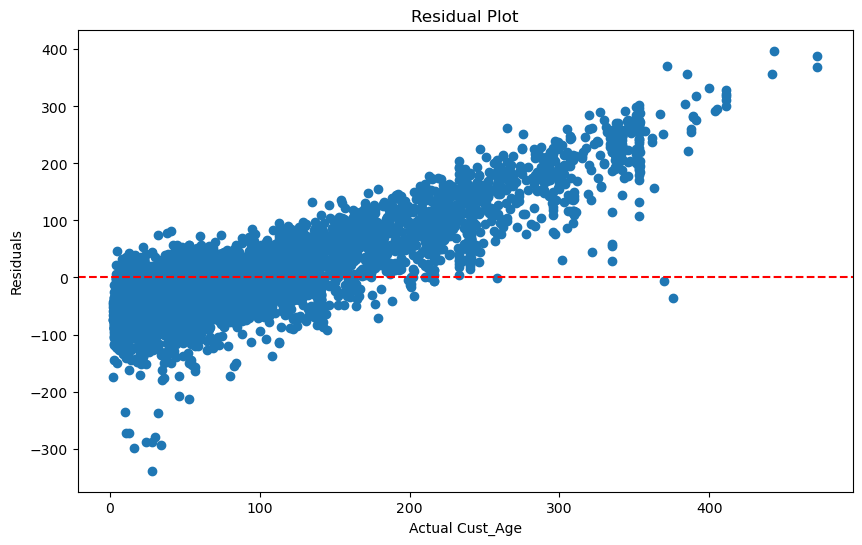

In [25]:
residuals = y_test - y_pred

# Plot residuals
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(y_test, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel("Actual Cust_Age")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.show()


In [23]:
# Not looking so hot. We can probably do better.

## Random Forest

In [26]:
# Instantiate TruncatedSVD
svd = TruncatedSVD(random_state=42)

# Define the Random Forest model
rf_model = RandomForestRegressor(random_state=42, n_jobs=-1)

# Combine the preprocessor, TruncatedSVD, and Random Forest into a pipeline
full_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('svd', svd),
    ('rf_model', rf_model)
])

# Define the hyperparameters for tuning
param_dist = {
    'rf_model__n_estimators': [100, 200, 300],
    'rf_model__max_depth': [10, 20, 30],
    'rf_model__min_samples_split': [2, 5, 10],
    'rf_model__min_samples_leaf': [1, 2, 4],
    'svd__n_components': np.arange(50, 150, 10)
}

# Instantiate the RandomizedSearchCV object
random_search = RandomizedSearchCV(full_pipeline, param_dist, n_iter=10, cv=4, scoring='neg_mean_squared_error', n_jobs=-1, verbose=1, random_state=42)

# Fit the random search to the training data
random_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = random_search.best_params_
print("Best hyperparameters:", best_params)

# Get the best model
best_model = random_search.best_estimator_

# Evaluate the best model on the test set
y_pred = best_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("Mean squared error on the test set:", mse)

Fitting 4 folds for each of 10 candidates, totalling 40 fits
Best hyperparameters: {'svd__n_components': 110, 'rf_model__n_estimators': 200, 'rf_model__min_samples_split': 10, 'rf_model__min_samples_leaf': 4, 'rf_model__max_depth': 30}
Mean squared error on the test set: 4850.8728117845185


In [29]:
print(best_params)
print(mse)

{'svd__n_components': 110, 'rf_model__n_estimators': 200, 'rf_model__min_samples_split': 10, 'rf_model__min_samples_leaf': 4, 'rf_model__max_depth': 30}
4850.8728117845185


## Decision Tree Regression

In [31]:
# This is taking too long.
# Define the TruncatedSVD transformer
svd = TruncatedSVD(n_components=100)

# Define the Decision Tree model
dt_model = DecisionTreeRegressor(random_state=42)

# Combine the preprocessor, TruncatedSVD, and Decision Tree into a pipeline
full_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('svd', svd),
    ('dt_model', dt_model)
])

# Define the hyperparameters for tuning
param_grid = {
    'dt_model__max_depth': [5, 10, 15, 20],
    'dt_model__min_samples_split': [2, 5, 10],
    'dt_model__min_samples_leaf': [1, 2, 4]
}

# Instantiate the GridSearchCV object
grid_search = GridSearchCV(full_pipeline, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, verbose=1, error_score='raise')

# Fit the grid search to the training data
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_
print("Best hyperparameters:", best_params)

# Get the best model
best_model = grid_search.best_estimator_

# Evaluate the best model on the test set
y_pred = best_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("Mean squared error on the test set:", mse)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


In [26]:
# Create a Decision Tree Regression model
tree_model = DecisionTreeRegressor()

# Train the model using the preprocessed training data
tree_model.fit(X_train_preprocessed, y_train)

# Make predictions on the preprocessed testing data
y_pred_tree = tree_model.predict(X_test_preprocessed)

# Calculate the Mean Squared Error (MSE) and R-squared (R2) score
mse_tree = mean_squared_error(y_test, y_pred_tree)
r2_tree = r2_score(y_test, y_pred_tree)

print(f"Mean Squared Error: {mse_tree:.2f}")
print(f"R-squared: {r2_tree:.2f}")

#takes forever

## Gradient Boosting Regression

In [31]:

# Define the Gradient Boosting model
gb_model = GradientBoostingRegressor(random_state=42)

# Combine the preprocessor, TruncatedSVD, and Gradient Boosting into a pipeline
full_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('svd', svd),
    ('gb_model', gb_model)
])

# Define the hyperparameters for tuning
param_dist = {
    'gb_model__n_estimators': [100, 200, 300],
    'gb_model__learning_rate': [0.01, 0.1, 0.2],
    'gb_model__max_depth': [3, 5, 7],
    'gb_model__min_samples_split': [2, 5, 10],
    'gb_model__min_samples_leaf': [1, 2, 4],
    'svd__n_components': np.arange(50, 150, 10)
}

# Instantiate the RandomizedSearchCV object
random_search = RandomizedSearchCV(full_pipeline, param_dist, n_iter=20, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, verbose=1, random_state=42)

# Fit the random search to the training data
random_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = random_search.best_params_
print("Best hyperparameters:", best_params)

# Get the best model
best_model = random_search.best_estimator_

# Evaluate the best model on the test set
y_pred = best_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("Mean squared error on the test set:", mse)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
